1]. Problem Statement: Lane Detection and Segmentation

2]. Objective:
Implement an ENet architecture for lane detection and segmentation using deep learning techniques. The model should accurately predict binary segmentation masks and instance embeddings for lanes in urban scenes.

3]. Details:

Dataset: Utilize the TuSimple dataset for training and evaluation, containing images and corresponding lane annotations in JSON format.

Model Architecture: Implement the ENet architecture comprising:
        InitialBlock for initial feature extraction.
        Multiple DownsamplingBottleneck and RegularBottleneck blocks for hierarchical feature extraction.
        Separate branches for binary segmentation and instance embedding prediction using UpsamplingBottleneck blocks.

Loss Functions:
        Binary Segmentation: Cross-entropy loss.
        Instance Embedding: Custom Discriminative Loss, incorporating variance, distance, and regularization components to enhance instance embedding quality.

Training: Train the model using stochastic gradient descent (SGD) with momentum.

Evaluation: Evaluate the model on a separate evaluation set using standard metrics for lane detection and segmentation tasks.

7]. Expected Output: Trained model capable of accurate lane detection and segmentation in urban driving scenarios, suitable for real-time applications.

In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import tqdm
from torch.utils.tensorboard import SummaryWriter  # Added for TensorBoard

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/Users/dakshpatel/Desktop/Computer_Vision/Project/Code/TuSimple_Dataset/TUSimple/train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h

        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))

class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)

class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices

class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue 
                    else:
                        distance=torch.norm(clusters[index]-cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cpu")
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss

# Constants for training
BATCH_SIZE = 8
LR = 5e-4
NUM_EPOCHS = 32

# Create the training dataset and dataloader
train_dataset = LaneDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cpu")

# Create the ENet model and move it to the CPU device
enet_model = ENet(2, 4)
enet_model.to(device)

# Define the optimizer
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

# Create a directory for logs
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Set up TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Lists to store losses and accuracies
binary_losses_epoch = []
instance_losses_epoch = []
train_accuracies = []
fprs = []
fnrs = []

# Training loop
for epoch in range(NUM_EPOCHS):
    enet_model.train()
    losses = []
    correct_binary = 0
    total_pixels = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0
    true_positives = 0
    
    for batch in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        optimizer.zero_grad()

        binary_logits, instance_emb = enet_model(img)

        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()

        optimizer.step()

        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

        binary_preds = torch.argmax(binary_logits, dim=1)
        correct_binary += torch.sum(binary_preds == binary_target).item()
        total_pixels += binary_target.numel()
        
        true_positives += torch.sum((binary_preds == 1) & (binary_target == 1)).item()
        false_positives += torch.sum((binary_preds == 1) & (binary_target == 0)).item()
        true_negatives += torch.sum((binary_preds == 0) & (binary_target == 0)).item()
        false_negatives += torch.sum((binary_preds == 0) & (binary_target == 1)).item()

    binary_accuracy = correct_binary / total_pixels
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)

    train_accuracies.append(binary_accuracy)
    fprs.append(fpr)
    fnrs.append(fnr)

    mean_losses = np.array(losses).mean(axis=0)
    binary_losses_epoch.append(mean_losses[0])
    instance_losses_epoch.append(mean_losses[1])

    # Log metrics to TensorBoard
    writer.add_scalar("Binary Loss", mean_losses[0], epoch)
    writer.add_scalar("Instance Loss", mean_losses[1], epoch)
    writer.add_scalar("Binary Accuracy", binary_accuracy, epoch)
    writer.add_scalar("False Positive Rate", fpr, epoch)
    writer.add_scalar("False Negative Rate", fnr, epoch)

    # Log details of all layers in histogram format
    for name, param in enet_model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=epoch)

    # Print and save results for this epoch
    msg = (f"Epoch {epoch}:"
          f" Binary Loss = {mean_losses[0]:.4f}, Instance Loss = {mean_losses[1]:.4f}, Binary Accuracy = {binary_accuracy:.4f}, FPR = {fpr:.4f}, FNR = {fnr:.4f}")
    print(msg)

# Close TensorBoard writer
writer.close()


2024-06-11 02:01:57.998757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|█████████████████████████████████████████| 402/402 [45:45<00:00,  6.83s/it]


Epoch 0: Binary Loss = 0.1506, Instance Loss = 2.3146, Binary Accuracy = 0.9539, FPR = 0.0207, FNR = 0.9605


100%|█████████████████████████████████████████| 402/402 [48:18<00:00,  7.21s/it]


Epoch 1: Binary Loss = 0.0598, Instance Loss = 0.4234, Binary Accuracy = 0.9734, FPR = 0.0008, FNR = 0.9531


100%|█████████████████████████████████████████| 402/402 [52:31<00:00,  7.84s/it]


Epoch 2: Binary Loss = 0.0529, Instance Loss = 0.2838, Binary Accuracy = 0.9740, FPR = 0.0009, FNR = 0.9293


100%|█████████████████████████████████████████| 402/402 [51:29<00:00,  7.69s/it]


Epoch 3: Binary Loss = 0.0505, Instance Loss = 0.2233, Binary Accuracy = 0.9746, FPR = 0.0014, FNR = 0.8884


100%|█████████████████████████████████████████| 402/402 [33:38<00:00,  5.02s/it]


Epoch 4: Binary Loss = 0.0487, Instance Loss = 0.1883, Binary Accuracy = 0.9754, FPR = 0.0017, FNR = 0.8490


100%|█████████████████████████████████████████| 402/402 [34:01<00:00,  5.08s/it]


Epoch 5: Binary Loss = 0.0481, Instance Loss = 0.1791, Binary Accuracy = 0.9752, FPR = 0.0017, FNR = 0.8527


100%|███████████████████████████████████████| 402/402 [4:15:46<00:00, 38.18s/it]


Epoch 6: Binary Loss = 0.0473, Instance Loss = 0.1435, Binary Accuracy = 0.9756, FPR = 0.0019, FNR = 0.8319


100%|██████████████████████████████████████| 402/402 [10:02:15<00:00, 89.89s/it]


Epoch 7: Binary Loss = 0.0471, Instance Loss = 0.1460, Binary Accuracy = 0.9759, FPR = 0.0021, FNR = 0.8153


100%|█████████████████████████████████████████| 402/402 [39:28<00:00,  5.89s/it]


Epoch 8: Binary Loss = 0.0467, Instance Loss = 0.1307, Binary Accuracy = 0.9762, FPR = 0.0024, FNR = 0.7928


100%|█████████████████████████████████████████| 402/402 [40:22<00:00,  6.03s/it]


Epoch 9: Binary Loss = 0.0461, Instance Loss = 0.1116, Binary Accuracy = 0.9766, FPR = 0.0026, FNR = 0.7701


100%|█████████████████████████████████████████| 402/402 [38:58<00:00,  5.82s/it]


Epoch 10: Binary Loss = 0.0456, Instance Loss = 0.1088, Binary Accuracy = 0.9776, FPR = 0.0035, FNR = 0.7015


100%|█████████████████████████████████████████| 402/402 [38:01<00:00,  5.68s/it]


Epoch 11: Binary Loss = 0.0439, Instance Loss = 0.0909, Binary Accuracy = 0.9809, FPR = 0.0069, FNR = 0.4575


100%|█████████████████████████████████████████| 402/402 [38:08<00:00,  5.69s/it]


Epoch 12: Binary Loss = 0.0430, Instance Loss = 0.0676, Binary Accuracy = 0.9814, FPR = 0.0072, FNR = 0.4297


100%|█████████████████████████████████████████| 402/402 [39:52<00:00,  5.95s/it]


Epoch 13: Binary Loss = 0.0424, Instance Loss = 0.0659, Binary Accuracy = 0.9817, FPR = 0.0071, FNR = 0.4230


100%|█████████████████████████████████████████| 402/402 [37:35<00:00,  5.61s/it]


Epoch 14: Binary Loss = 0.0423, Instance Loss = 0.0651, Binary Accuracy = 0.9817, FPR = 0.0070, FNR = 0.4242


100%|█████████████████████████████████████████| 402/402 [35:10<00:00,  5.25s/it]


Epoch 15: Binary Loss = 0.0415, Instance Loss = 0.0539, Binary Accuracy = 0.9819, FPR = 0.0070, FNR = 0.4146


100%|█████████████████████████████████████████| 402/402 [34:42<00:00,  5.18s/it]


Epoch 16: Binary Loss = 0.0411, Instance Loss = 0.0465, Binary Accuracy = 0.9821, FPR = 0.0070, FNR = 0.4096


100%|█████████████████████████████████████████| 402/402 [25:32<00:00,  3.81s/it]


Epoch 17: Binary Loss = 0.0409, Instance Loss = 0.0466, Binary Accuracy = 0.9822, FPR = 0.0070, FNR = 0.4046


100%|█████████████████████████████████████████| 402/402 [23:33<00:00,  3.52s/it]


Epoch 18: Binary Loss = 0.0407, Instance Loss = 0.0415, Binary Accuracy = 0.9823, FPR = 0.0070, FNR = 0.4021


100%|█████████████████████████████████████████| 402/402 [24:59<00:00,  3.73s/it]


Epoch 19: Binary Loss = 0.0405, Instance Loss = 0.0388, Binary Accuracy = 0.9824, FPR = 0.0070, FNR = 0.3992


100%|█████████████████████████████████████████| 402/402 [26:31<00:00,  3.96s/it]


Epoch 20: Binary Loss = 0.0403, Instance Loss = 0.0395, Binary Accuracy = 0.9825, FPR = 0.0070, FNR = 0.3964


100%|█████████████████████████████████████████| 402/402 [27:03<00:00,  4.04s/it]


Epoch 21: Binary Loss = 0.0398, Instance Loss = 0.0279, Binary Accuracy = 0.9826, FPR = 0.0069, FNR = 0.3920


100%|█████████████████████████████████████████| 402/402 [27:56<00:00,  4.17s/it]


Epoch 22: Binary Loss = 0.0398, Instance Loss = 0.0315, Binary Accuracy = 0.9827, FPR = 0.0070, FNR = 0.3893


100%|█████████████████████████████████████████| 402/402 [28:32<00:00,  4.26s/it]


Epoch 23: Binary Loss = 0.0394, Instance Loss = 0.0263, Binary Accuracy = 0.9828, FPR = 0.0069, FNR = 0.3863


100%|█████████████████████████████████████████| 402/402 [29:16<00:00,  4.37s/it]


Epoch 24: Binary Loss = 0.0395, Instance Loss = 0.0340, Binary Accuracy = 0.9828, FPR = 0.0069, FNR = 0.3888


100%|█████████████████████████████████████████| 402/402 [30:11<00:00,  4.51s/it]


Epoch 25: Binary Loss = 0.0392, Instance Loss = 0.0276, Binary Accuracy = 0.9829, FPR = 0.0068, FNR = 0.3862


100%|█████████████████████████████████████████| 402/402 [30:51<00:00,  4.61s/it]


Epoch 26: Binary Loss = 0.0392, Instance Loss = 0.0285, Binary Accuracy = 0.9829, FPR = 0.0069, FNR = 0.3850


100%|█████████████████████████████████████████| 402/402 [32:06<00:00,  4.79s/it]


Epoch 27: Binary Loss = 0.0390, Instance Loss = 0.0263, Binary Accuracy = 0.9830, FPR = 0.0069, FNR = 0.3834


100%|█████████████████████████████████████████| 402/402 [32:55<00:00,  4.91s/it]


Epoch 28: Binary Loss = 0.0390, Instance Loss = 0.0247, Binary Accuracy = 0.9830, FPR = 0.0069, FNR = 0.3824


100%|█████████████████████████████████████████| 402/402 [33:03<00:00,  4.93s/it]


Epoch 29: Binary Loss = 0.0387, Instance Loss = 0.0246, Binary Accuracy = 0.9831, FPR = 0.0069, FNR = 0.3798


100%|█████████████████████████████████████| 402/402 [14:06:29<00:00, 126.34s/it]


Epoch 30: Binary Loss = 0.0387, Instance Loss = 0.0241, Binary Accuracy = 0.9831, FPR = 0.0068, FNR = 0.3793


100%|█████████████████████████████████████████| 402/402 [40:48<00:00,  6.09s/it]


Epoch 31: Binary Loss = 0.0391, Instance Loss = 0.0275, Binary Accuracy = 0.9829, FPR = 0.0069, FNR = 0.3847


In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np

def extract_lane_points(binary_segmentation):
    """
    Extract lane points from the binary segmentation image.
    
    Parameters:
    binary_segmentation (numpy.ndarray): Binary segmentation image.
    
    Returns:
    list: List of lane points (x, y).
    """
    points = np.column_stack(np.where(binary_segmentation > 0))
    return points

def fit_line_to_points(points):
    """
    Fit a line to the given points using linear regression.
    
    Parameters:
    points (list): List of lane points (x, y).
    
    Returns:
    tuple: Slope and intercept of the fitted line.
    """
    if len(points) < 2:
        return None, None  # Not enough points to fit a line
    
    x = points[:, 1].reshape(-1, 1)
    y = points[:, 0].reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]
    
    return slope, intercept

def calculate_angle(slope):
    """
    Calculate the angle of the line with respect to the horizontal axis.
    
    Parameters:
    slope (float): Slope of the line.
    
    Returns:
    float: Angle in degrees.
    """
    angle_rad = np.arctan(slope)
    angle_deg = np.degrees(angle_rad)
    return angle_deg


In [3]:
def plot_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        batch = next(iter(dataloader))
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)

        binary_logits, instance_emb = model(img)
        binary_preds = torch.argmax(binary_logits, dim=1)

        img = img.cpu().numpy()
        binary_preds = binary_preds.cpu().numpy()
        binary_target = binary_target.cpu().numpy()

        fig, axes = plt.subplots(len(img), 3, figsize=(15, 5 * len(img)))

        for i in range(len(img)):
            ax = axes[i, 0]
            ax.imshow(img[i].transpose((1, 2, 0)).squeeze(), cmap='gray')
            ax.set_title("Input Image")
            ax.axis("off")

            ax = axes[i, 1]
            ax.imshow(binary_preds[i], cmap='gray')
            ax.set_title("Predicted Segmentation")
            ax.axis("off")

            # Extract lane points and calculate angle
            points = extract_lane_points(binary_preds[i])
            slope, intercept = fit_line_to_points(points)
            if slope is not None:
                angle = calculate_angle(slope)
                ax.set_title(f"Predicted Segmentation\nAngle: {angle:.2f}°")
            else:
                ax.set_title("Predicted Segmentation\nNo lane detected")

            ax = axes[i, 2]
            ax.imshow(binary_target[i].squeeze(), cmap='gray')
            ax.set_title("Actual Segmentation")
            ax.axis("off")

        plt.tight_layout()
        plt.show()


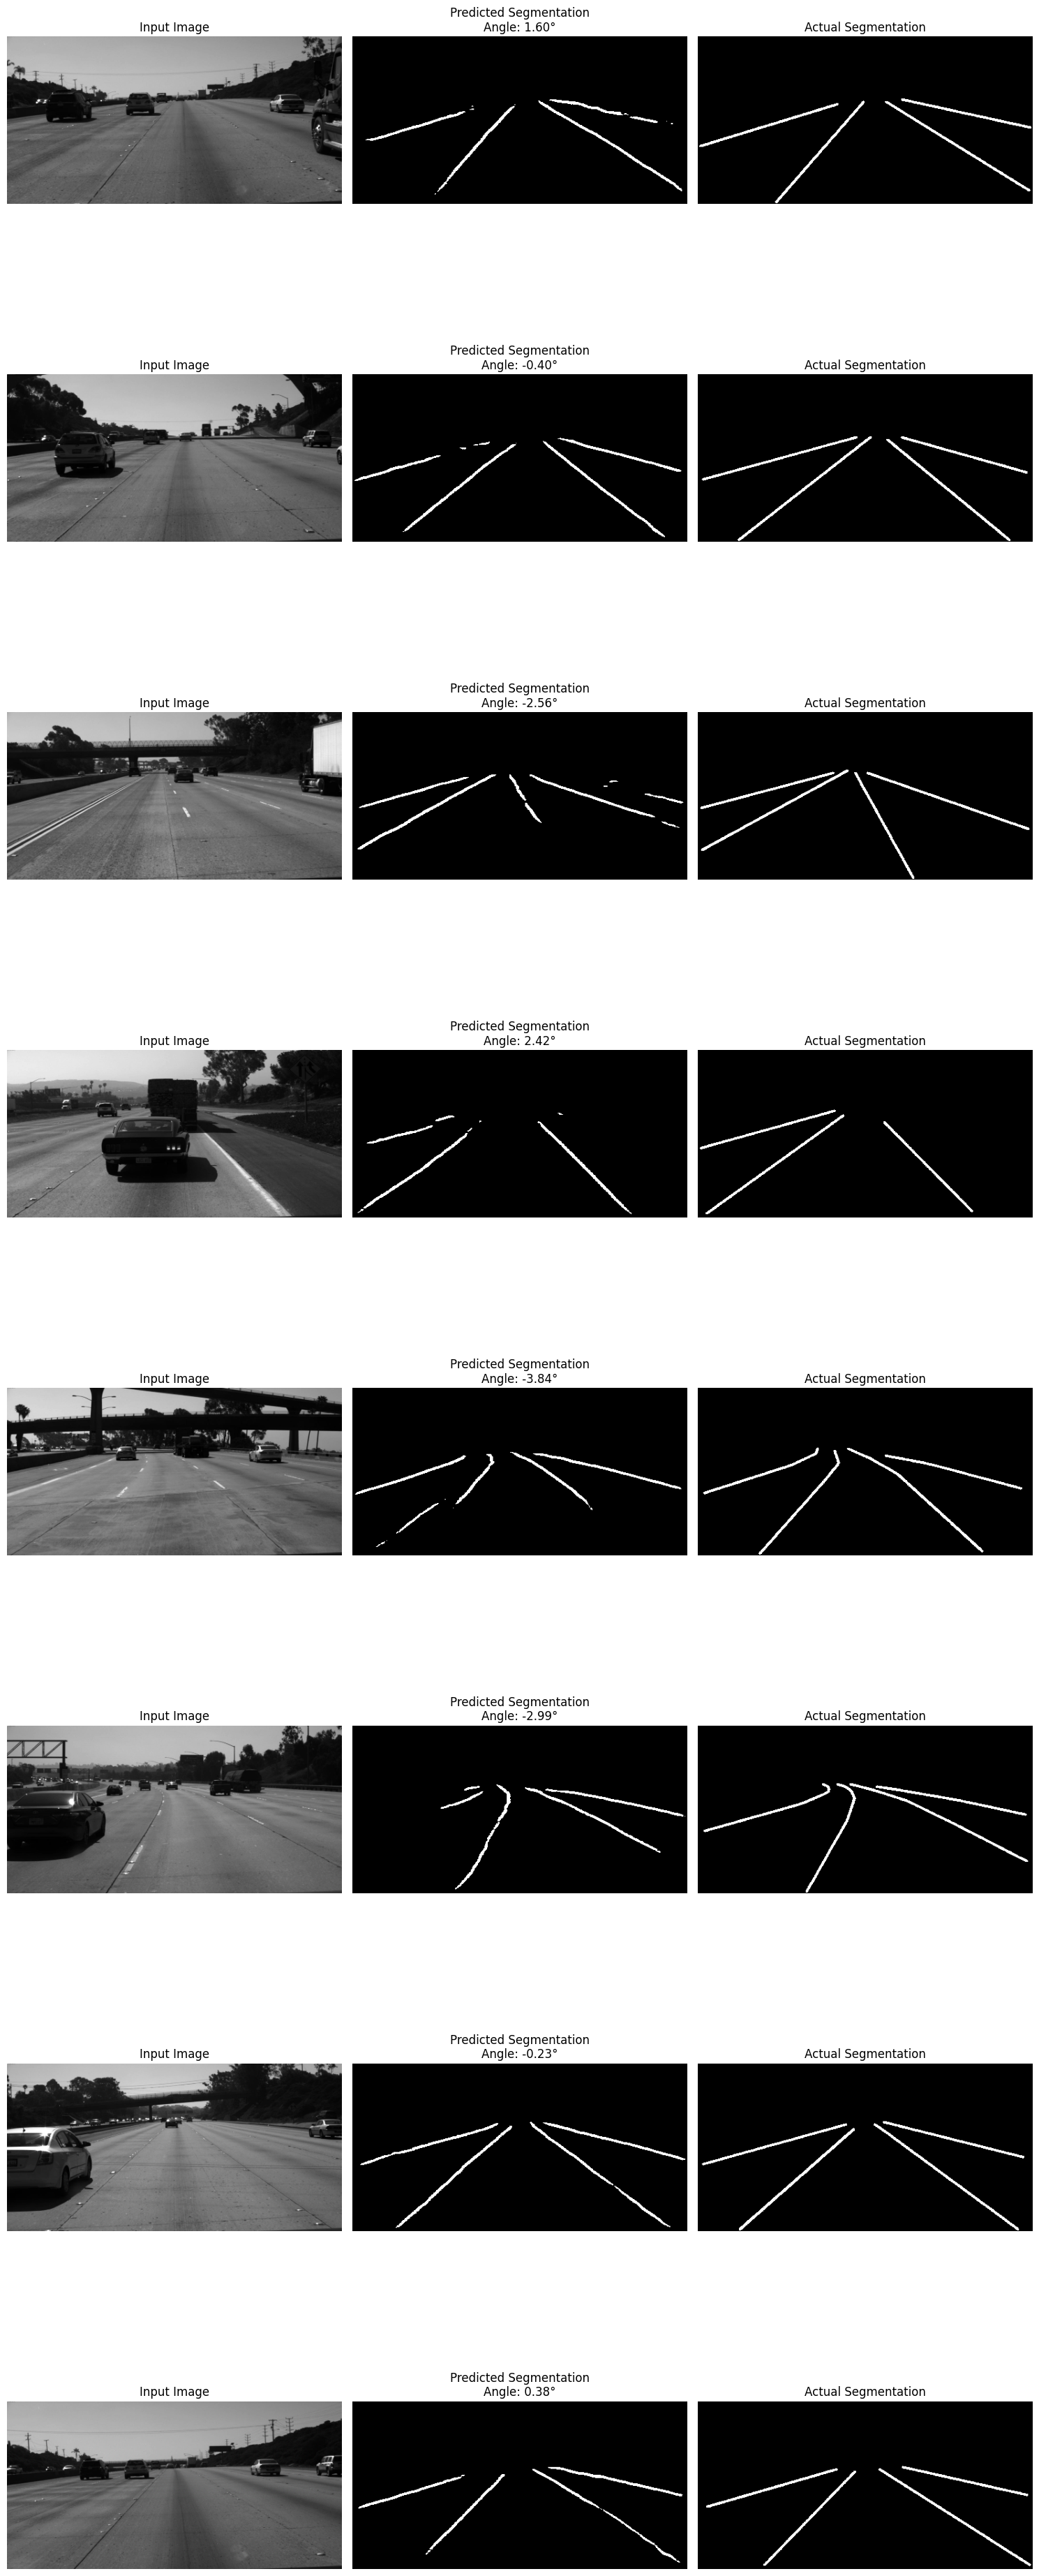

In [4]:
plot_predictions(enet_model, train_dataloader, device)